In [1]:
import os
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd
pd.options.mode.chained_assignment = None;
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.manifold import TSNE

from tensorflow.keras.applications import MobileNetV3Small


from collections import Counter

import random
import re

import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

def seed_it_all(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_it_all()

C:\Users\ibuku\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
print(os.listdir(r'C:\Users\ibuku\Music\ODIR-5K\ODIR-5K'))
test_image=r'C:\Users\ibuku\Music\ODIR-5K\ODIR-5K\Testing Images'
train_image=r'C:\Users\ibuku\Music\ODIR-5K\ODIR-5K\Training Images'

['data.xlsx', 'Testing Images', 'Training Images']


In [3]:
data=pd.read_csv('full_df.csv')

In [4]:
data

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4686_left.jpg
6388,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4688_left.jpg
6389,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4689_left.jpg
6390,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4690_left.jpg


In [5]:
def has_condn(term,text):
    if term in text:
        return 1
    else:
        return 0

In [6]:
data[data.O==1].head(20)  #drusen or epiretinal membrane

def process_dataset(data):
    #create 2 more columns labelling them whether right or left cataract
    data["left_cataract"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
    data["right_cataract"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
    
    data["LD"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))
    data["RD"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))

    data["LG"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    data["RG"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    
    data["LH"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))
    data["RH"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))

    data["LM"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    data["RM"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    
    data["LA"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    data["RA"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    
    data["LO"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    data["RO"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    
    #store the right/left cataract images ids in a array
    left_cataract_images = data.loc[(data.C ==1) & (data.left_cataract == 1)]["Left-Fundus"].values
    right_cataract_images = data.loc[(data.C == 1) & (data.right_cataract == 1)]["Right-Fundus"].values
    
    #store the left/right normal image ids in a array
    left_normal = data.loc[(data.C == 0) & (data["Left-Diagnostic Keywords"] == "normal fundus")]['Left-Fundus'].sample(350,random_state=42).values
    right_normal = data.loc[(data.C == 0) & (data["Right-Diagnostic Keywords"] == "normal fundus")]['Right-Fundus'].sample(350,random_state=42).values
    
    #store the left/right diabetes image ids
    left_diab = data.loc[(data.C == 0) & (data.LD == 1)]["Left-Fundus"].values
    right_diab = data.loc[(data.C == 0) & (data.RD == 1)]["Right-Fundus"].values 

    #store the left/right glaucoma image ids
    left_glaucoma = data.loc[(data.C == 0) & (data.LG == 1)]["Left-Fundus"].values
    right_glaucoma = data.loc[(data.C == 0) & (data.RG == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_hyper = data.loc[(data.C == 0) & (data.LH == 1)]["Left-Fundus"].values
    right_hyper = data.loc[(data.C == 0) & (data.RH == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_myopia = data.loc[(data.C == 0) & (data.LM == 1)]["Left-Fundus"].values
    right_myopia = data.loc[(data.C == 0) & (data.RM == 1)]["Right-Fundus"].values 
       
    #store the left/right diabetes image ids
    left_age = data.loc[(data.C == 0) & (data.LA == 1)]["Left-Fundus"].values
    right_age = data.loc[(data.C == 0) & (data.RA == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_other = data.loc[(data.C == 0) & (data.LO == 1)]["Left-Fundus"].values
    right_other = data.loc[(data.C == 0) & (data.RO == 1)]["Right-Fundus"].values 
    
    normalones = np.concatenate((left_normal,right_normal),axis = 0);
    cataractones = np.concatenate((left_cataract_images,right_cataract_images),axis = 0);
    diabones = np.concatenate((left_diab,right_diab),axis = 0);
    glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis = 0);
    hyper = np.concatenate((left_hyper,right_hyper),axis = 0);
    myopia = np.concatenate((left_myopia,right_myopia),axis = 0);
    age = np.concatenate((left_age,right_age),axis=0);
    other = np.concatenate((left_other,right_other),axis = 0);
    
    return normalones,cataractones,diabones,glaucoma,hyper,myopia,age,other;

In [7]:

from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = r'C:\Users\ibuku\Music\preprocessed_images'
image_size=224
labels = []
dataset = []
def dataset_generator(imagecategory , label):
    for img in tqdm(imagecategory):
        #image category here would be either normal or cataract
        imgpath = os.path.join(dataset_dir,img);
        
        #now we try to read the image and resize it accordingly
        try:
            image = cv2.imread(imgpath,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue;
        dataset.append([np.array(image),np.array(label)]);
    random.shuffle(dataset);
    
    return dataset;

In [8]:
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings 
warnings.simplefilter(action='ignore',category=FutureWarning)

In [9]:
normal , cataract , diab, glaucoma , hyper , myopia , age, other = process_dataset(data);

print("Dataset stats::")
print("Normal ::" , len(normal))
print("Cataract ::" , len(cataract))
print("Diabetes ::" , len(diab))
print("Glaucoma ::" , len(glaucoma))
print("Hypertension ::" , len(hyper))
print("Myopia ::" , len(myopia))
print("Age Issues ::" , len(age))
print("Other ::" , len(other))
print("*"*50)
print("Normal::\n")
print(normal)
print("*"*50)
print("*"*50)
print("Cataract::\n")
print(cataract)
print("*"*50)
print("*"*50)
print("Diabetes::\n")
print(diab)
print("*"*50)
print("*"*50)
print("Glaucoma::\n")
print(glaucoma)
print("*"*50)
print("*"*50)
print("HyperTension::\n")
print(hyper)
print("*"*50)
print("*"*50)
print("Myopia::\n")
print(myopia)
print("*"*50)
print("*"*50)
print("Age Related::\n")
print(age)
print("*"*50)
print("*"*50)
print("Other ::\n")
print(other)
print("*"*50)

Dataset stats::
Normal :: 700
Cataract :: 594
Diabetes :: 1818
Glaucoma :: 610
Hypertension :: 374
Myopia :: 479
Age Issues :: 551
Other :: 324
**************************************************
Normal::

['3332_left.jpg' '4059_left.jpg' '69_left.jpg' '2415_left.jpg'
 '4176_left.jpg' '2711_left.jpg' '4614_left.jpg' '3174_left.jpg'
 '2862_left.jpg' '2424_left.jpg' '3193_left.jpg' '3306_left.jpg'
 '2961_left.jpg' '2425_left.jpg' '2858_left.jpg' '3180_left.jpg'
 '2668_left.jpg' '2659_left.jpg' '2336_left.jpg' '277_left.jpg'
 '2897_left.jpg' '1151_left.jpg' '3011_left.jpg' '3083_left.jpg'
 '4059_left.jpg' '4576_left.jpg' '2563_left.jpg' '2549_left.jpg'
 '3025_left.jpg' '2330_left.jpg' '2562_left.jpg' '3438_left.jpg'
 '3047_left.jpg' '3150_left.jpg' '570_left.jpg' '2430_left.jpg'
 '2532_left.jpg' '3426_left.jpg' '2475_left.jpg' '3214_left.jpg'
 '1253_left.jpg' '2819_left.jpg' '3415_left.jpg' '2973_left.jpg'
 '2488_left.jpg' '2349_left.jpg' '3025_left.jpg' '3125_left.jpg'
 '160_left.jpg' '29

In [10]:
#Normal == 0
# Cataract == 1
# Diabetes == 2
# Glaucoma == 3
# HyperTension == 4
# Myopia == 5
# Age == 6
# Other == 7

dataset = dataset_generator(normal,0)
dataset = dataset_generator(cataract,1)
dataset = dataset_generator(diab,2)
dataset = dataset_generator(glaucoma,3)
dataset = dataset_generator(hyper,4)
dataset = dataset_generator(myopia,5)
dataset = dataset_generator(age,6)
dataset = dataset_generator(other,7)

len(dataset)

100%|███████████████████████████████████████████████████████████████████████████████| 324/324 [00:01<00:00, 191.87it/s]


5396

In [11]:
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

In [12]:
def check_disease(df,start,end): 
    df = df.iloc[:, start:end] 
    disease_name, zeroCount, oneCount =[], [], []
    rowLen = len(df) 
    for (column_name, column) in df.iteritems(): 
        disease_name.append(column_name) 
        zeroCount.append(df[column_name].value_counts()[0]) 
        oneCount = [rowLen - x for x in zeroCount] 
        return disease_name, zeroCount, oneCount

In [14]:
male=len(data[data['Patient Sex']=='Male'])
female=len(data[data['Patient Sex']=='Female'])
print('the total number of male is',male)
print('===========================================')
print('the total number of female is',female)

the total number of male is 3424
the total number of female is 2968


In [15]:
import seaborn as sns

<BarContainer object of 2 artists>

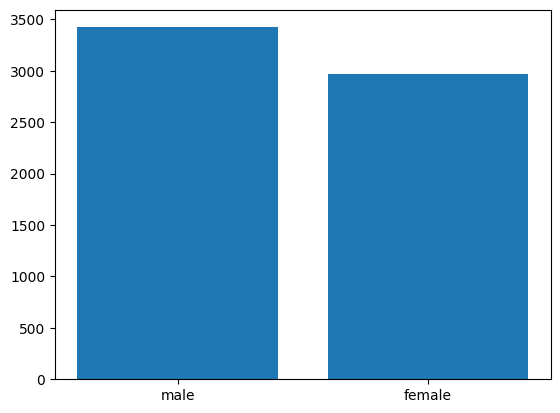

In [16]:
gender=[male,female]
range=['male','female']
plt.bar(range,gender)

In [17]:
n=len(data[data['labels']=="['N']"])
d=len(data[data['labels']=="['D']"])
g=len(data[data['labels']=="['G']"])
c=len(data[data['labels']=="['C']"])
h=len(data[data['labels']=="['H']"])
m=len(data[data['labels']=="['M']"])
Age=len(data[data['labels']=="['A']"])
o=len(data[data['labels']=="['O']"])

print('the total number of normal eye images in the data is',n)
print('==============================================================')
print('the total number of diabetes eye images in the data is',d)
print('==============================================================')
print('the total number of glaucoma eye images in the data is',g)
print('==============================================================')
print('the total number of cataract eye images in the data is',c)
print('==============================================================')
print('the total number of hyptertension eye images in the data is',h)
print('==============================================================')
print('the total number of myopia eye images in the data is',m)
print('==============================================================')
print('the total number of Age issue eye images in the data is',Age)
print('==============================================================')
print('the total number of other eye images in the data is',o)
print('===============================================================')



the total number of normal eye images in the data is 2873
the total number of diabetes eye images in the data is 1608
the total number of glaucoma eye images in the data is 284
the total number of cataract eye images in the data is 293
the total number of hyptertension eye images in the data is 128
the total number of myopia eye images in the data is 232
the total number of Age issue eye images in the data is 266
the total number of other eye images in the data is 708


<BarContainer object of 8 artists>

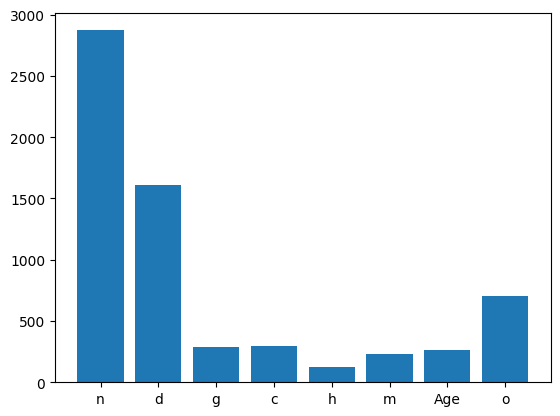

In [18]:
disease=[n,d,g,c,h,m,Age,o]
ranges=['n','d','g','c','h','m','Age','o']
plt.bar(ranges,disease)

In [19]:
male_n=data[(data['Patient Sex']=='Male')&(data['labels']=="['N']")].shape[0]
male_d=data[(data['Patient Sex']=='Male')&(data['labels']=="['D']")].shape[0]
male_g=data[(data['Patient Sex']=='Male')&(data['labels']=="['G']")].shape[0]
male_c=data[(data['Patient Sex']=='Male')&(data['labels']=="['C']")].shape[0]
male_h=data[(data['Patient Sex']=='Male')&(data['labels']=="['H']")].shape[0]
male_m=data[(data['Patient Sex']=='Male')&(data['labels']=="['M']")].shape[0]
male_a=data[(data['Patient Sex']=='Male')&(data['labels']=="['A']")].shape[0]
male_o=data[(data['Patient Sex']=='Male')&(data['labels']=="['O']")].shape[0]

## print('====================================================================')
female_n=data[(data['Patient Sex']=='Female')&(data['labels']=="['N']")].shape[0]
female_d=data[(data['Patient Sex']=='Female')&(data['labels']=="['D']")].shape[0]
female_g=data[(data['Patient Sex']=='Female')&(data['labels']=="['G']")].shape[0]
female_c=data[(data['Patient Sex']=='Female')&(data['labels']=="['C']")].shape[0]
female_h=data[(data['Patient Sex']=='Female')&(data['labels']=="['H']")].shape[0]
female_m=data[(data['Patient Sex']=='Female')&(data['labels']=="['M']")].shape[0]
female_a=data[(data['Patient Sex']=='Female')&(data['labels']=="['A']")].shape[0]
female_o=data[(data['Patient Sex']=='Female')&(data['labels']=="['O']")].shape[0]

##print('=====================================================================')
print('the total number of male with normal image is ',male_n)
print('====================================================')
print('the total number of male with diabetes image is ',male_d)
print('====================================================')
print('the total number of male with glaucoma image is ',male_g)
print('====================================================')
print('the total number of male with cataract image is ',male_c)
print('====================================================')
print('the total number of male with hyptertension image is ',male_h)
print('====================================================')
print('the total number of male with myopia image is ',male_m)
print('====================================================')
print('the total number of male with Age issues image is ',male_a)
print('====================================================')
print('the total number of male with others image is ',male_o)
print('====================================================')
print('====================================================')
print('====================================================')
print('====================================================')
## print('====================================================================
#print('=====================================================================')
print('the total number of female with normal image is ',female_n)
print('====================================================')
print('the total number of female with diabetes image is ',female_d)
print('====================================================')
print('the total number of female with glaucoma image is ',female_g)
print('====================================================')
print('the total number of female with cataract image is ',female_c)
print('====================================================')
print('the total number of female with hyptertension image is ',female_h)
print('====================================================')
print('the total number of female with myopia image is ',female_m)
print('====================================================')
print('the total number of female with Age issues image is ',female_a)
print('====================================================')
print('the total number of female with others image is ',female_o)
print('====================================================')
print('====================================================')
print('====================================================')
print('====================================================')


the total number of male with normal image is  1568
the total number of male with diabetes image is  916
the total number of male with glaucoma image is  166
the total number of male with cataract image is  125
the total number of male with hyptertension image is  81
the total number of male with myopia image is  75
the total number of male with Age issues image is  141
the total number of male with others image is  352
the total number of female with normal image is  1305
the total number of female with diabetes image is  692
the total number of female with glaucoma image is  118
the total number of female with cataract image is  168
the total number of female with hyptertension image is  47
the total number of female with myopia image is  157
the total number of female with Age issues image is  125
the total number of female with others image is  356


<BarContainer object of 8 artists>

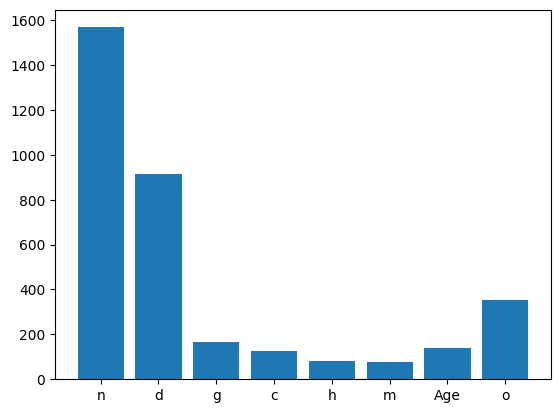

In [20]:
disease1=[male_n,male_d,male_g,male_c,male_h,male_m,male_a,male_o]
ranges1=['n','d','g','c','h','m','Age','o']
plt.bar(ranges1,disease1)

<BarContainer object of 8 artists>

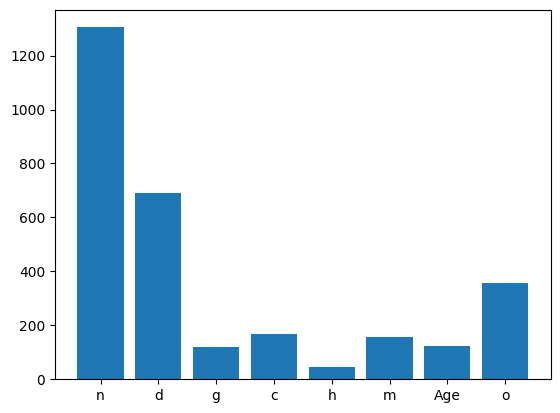

In [21]:
disease2=[female_n,female_d,female_g,female_c,female_h,female_m,female_a,female_o]
ranges2=['n','d','g','c','h','m','Age','o']
plt.bar(ranges2,disease2)

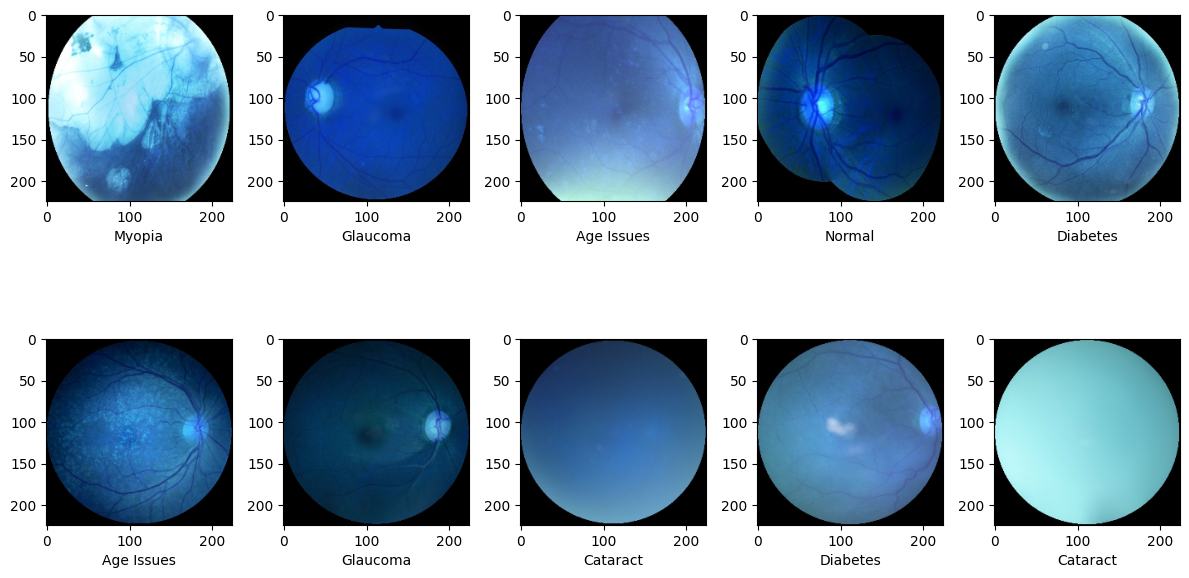

In [12]:
plt.figure(figsize=(12,7))
for i in range (10):
    sample=random.choice(range(len(dataset)))
    image=dataset[sample][0]
    category=dataset[sample][1]
    if category==0:
        label='Normal'
    elif category==1:
        label='Cataract'
    elif category==2:
        label='Diabetes'
    elif category==3:
        label='Glaucoma'
    elif category==4:
        label='HyperTension'
    elif category==5:
        label='Myopia'
    elif category==6:
        label='Age Issues'
    else:
        label='Other'
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [13]:
#Divide the dataset into 2 predictors and target...
#here predictors would be the image and target would be the label

train_x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3);
train_y = np.array([i[1] for i in dataset])

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
#splitting the dataset
x_train , x_test , y_train, y_test = train_test_split(train_x,train_y, test_size=0.2)

y_train_cat = to_categorical(y_train,num_classes=8)

y_test_cat = to_categorical(y_test,num_classes = 8)

In [23]:
from sklearn import preprocessing as pp

In [24]:
label_encoder=pp.LabelEncoder()
label_encoder

LabelEncoder()

In [25]:
data=data.drop('ID',axis=1)

In [26]:
data

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,...,LG,RG,LH,RH,LM,RM,LA,RA,LO,RO
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6388,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6389,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6390,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
numeric=data.select_dtypes(np.number)
numeric

,Patient Age,N,D,G,C,A,H,M,O,left_cataract,...,LG,RG,LH,RH,LM,RM,LA,RA,LO,RO
0,69,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,57,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,42,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,53,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,50,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,63,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6388,42,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6389,54,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6390,57,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
Objects=data.select_dtypes('object')
Objects

,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,filepath,labels,target,filename
0,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
...,...,...,...,...,...,...,...,...,...
6387,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4686_left.jpg
6388,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4688_left.jpg
6389,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4689_left.jpg
6390,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4690_left.jpg


In [29]:
Objects=Objects.drop(Objects.columns[5],axis=1)
Objects

,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,labels,target,filename
0,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
...,...,...,...,...,...,...,...,...
6387,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4686_left.jpg
6388,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4688_left.jpg
6389,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4689_left.jpg
6390,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4690_left.jpg


In [30]:
obj=Objects.columns.to_list()
obj

['Patient Sex',
 'Left-Fundus',
 'Right-Fundus',
 'Left-Diagnostic Keywords',
 'Right-Diagnostic Keywords',
 'labels',
 'target',
 'filename']

In [31]:
for column in obj:
    Objects[column]=label_encoder.fit_transform(Objects[column])

In [32]:
Objects

,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,labels,target,filename
0,0,0,0,4,151,6,7,1
1,1,628,628,146,151,6,7,1169
2,1,1537,1537,76,110,2,6,2920
3,1,2836,2836,94,102,2,6,5432
4,0,2940,2940,119,110,2,6,5626
...,...,...,...,...,...,...,...,...
6387,1,2798,2798,166,170,2,6,5361
6388,1,2799,2799,119,110,2,6,5363
6389,1,2800,2800,107,151,2,6,5365
6390,1,2802,2802,107,102,2,6,5369


In [33]:
data2=numeric.merge(Objects,right_index=True,left_index=True)
data2

,Patient Age,N,D,G,C,A,H,M,O,left_cataract,...,LO,RO,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,labels,target,filename
0,69,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,4,151,6,7,1
1,57,1,0,0,0,0,0,0,0,0,...,0,0,1,628,628,146,151,6,7,1169
2,42,0,1,0,0,0,0,0,1,0,...,0,0,1,1537,1537,76,110,2,6,2920
3,53,0,1,0,0,0,0,0,1,0,...,0,0,1,2836,2836,94,102,2,6,5432
4,50,0,1,0,0,0,0,0,0,0,...,0,0,0,2940,2940,119,110,2,6,5626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,63,0,1,0,0,0,0,0,0,0,...,0,0,1,2798,2798,166,170,2,6,5361
6388,42,0,1,0,0,0,0,0,0,0,...,0,0,1,2799,2799,119,110,2,6,5363
6389,54,0,1,0,0,0,0,0,0,0,...,0,0,1,2800,2800,107,151,2,6,5365
6390,57,0,1,0,0,0,0,0,0,0,...,0,0,1,2802,2802,107,102,2,6,5369


In [53]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression



# Split the dataset into features and labels

X = data2.drop('labels', axis=1)
y= data2['labels'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



# Standardize the feature values
SVM_model=SVC(kernel='linear',C=1.0)
SVM_model.fit(X_train,y_train)

##  training the dataset
y_pred_train=SVM_model.predict(X_train)
train_accuracy=accuracy_score(y_train,y_pred_train)
print('train_accuracy in SVM',y_pred_train,train_accuracy)
print('==========================================')

## testing the model
y_pred_test=SVM_model.predict(X_test)
test_accuracy=accuracy_score(y_test,y_pred_test)
print('test accuracy in svm',test_accuracy)
print('===============================================')


## working on KNN
KNN_model=KNeighborsClassifier()
KNN_model.fit(X_train,y_train)
##training the dataset
y_pred_train_KNN=KNN_model.predict(X_train)
train_accuracy_KNN=accuracy_score(y_train,y_pred_train_KNN)
print('train_accuracy in KNN',train_accuracy_KNN)
print('==================================================')
## testing the model
y_pred_test_KNN=KNN_model.predict(X_test)
test_accuracy_KNN=accuracy_score(y_test,y_pred_test_KNN)
print('test accuracy in KNN',test_accuracy_KNN)
print('===============================================')



## making using of Decision tree 
DTC_model=DecisionTreeClassifier()
DTC_model.fit(X_train,y_train)
##training the dataset
y_pred_train_DTC=DTC_model.predict(X_train)
train_accuracy_DTC=accuracy_score(y_train,y_pred_train_DTC)
print('train_accuracy in DTC',train_accuracy_DTC)
print('==================================================')
## testing the model
y_pred_test_DTC=DTC_model.predict(X_test)
test_accuracy_DTC=accuracy_score(y_test,y_pred_test_DTC)
print('test accuracy in DTC',test_accuracy_DTC)
print('===============================================')



## making use of randomforest which an ensemble algorithms in machine learning 
#RFC_model=RandomForestClassifier()
#RFC_model.fit(X_train,y_train)
##training the dataset
#y_pred_train_RFC=RFC_model.predict(X_train)
#train_accuracy_RFC=accuracy_score(y_train,y_pred_train_RFC)
#print('train_accuracy in RFC',train_accuracy_RFC)
#print('==================================================')
## testing the model
#y_pred_test_RFC=RFC_model.predict(X_test)
#test_accuracy_RFC=accuracy_score(y_test,y_pred_test_RFC)
#print('test accuracy in RFC',test_accuracy_RFC)
#print('===============================================')


LOG_model=LogisticRegression()
LOG_model.fit(X_train,y_train)
y_pred_train_LOG=LOG_model.predict(X_train)
train_accuracy_LOG=accuracy_score(y_train,y_pred_train_LOG)
print('train_accuracy in LOG',train_accuracy_LOG)
print('==================================================')
y_pred=LOG_model.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
print('test accuracy of LOG',accuracy)



train_accuracy in SVM [6 6 1 ... 6 6 7] 0.9992176804224526
test accuracy in svm 0.99687255668491
train_accuracy in KNN 0.973987874046548
test accuracy in KNN 0.9437060203283816
train_accuracy in DTC 1.0
test accuracy in DTC 1.0
train_accuracy in LOG 0.9978486211617446
test accuracy of LOG 0.9867083659108679


C:\Users\ibuku\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
from sklearn.metrics import accuracy_score,confusion_matrix
confusion_matrix_svm=confusion_matrix(y_test,y_pred_test)
confusion_matrix_KNN=confusion_matrix(y_test,y_pred_test_KNN)
confusion_matrix_DTC=confusion_matrix(y_test,y_pred_test_DTC)
confusion_matrix_LOG=confusion_matrix(y_test,y_pred)
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,classification_report 
from sklearn.metrics import roc_auc_score as roc
print('support vector machine')
print(confusion_matrix_svm)
print('=========================================================')
print('K-nearest kneighbors')
print(confusion_matrix_KNN)
print('=========================================================')
print('decision tree')
print(confusion_matrix_DTC)
print('=========================================================')
print('LOGISTIC REGRESSION')
print(confusion_matrix_LOG)

support vector machine
[[ 45   0   0   0   1   0   0   0]
 [  0  58   0   0   0   0   0   0]
 [  0   0 332   1   0   0   0   0]
 [  1   0   0  60   0   0   0   0]
 [  0   0   0   0  28   0   0   0]
 [  0   0   0   0   0  48   0   0]
 [  0   0   0   0   0   0 569   0]
 [  0   0   0   0   1   0   0 135]]
K-nearest kneighbors
[[ 40   0   1   0   0   0   5   0]
 [  0  54   4   0   0   0   0   0]
 [  3   6 314   2   0   0   7   1]
 [  1   0   2  56   0   0   0   2]
 [  1   0   0   1  26   0   0   0]
 [  0   0   0   0   0  48   0   0]
 [  2   2  19   4   0   0 542   0]
 [  0   4   1   0   0   4   0 127]]
decision tree
[[ 46   0   0   0   0   0   0   0]
 [  0  58   0   0   0   0   0   0]
 [  0   0 333   0   0   0   0   0]
 [  0   0   0  61   0   0   0   0]
 [  0   0   0   0  28   0   0   0]
 [  0   0   0   0   0  48   0   0]
 [  0   0   0   0   0   0 569   0]
 [  0   0   0   0   0   0   0 136]]
LOGISTIC REGRESSION
[[ 44   0   1   0   1   0   0   0]
 [  0  58   0   0   0   0   0   0]
 [  3   0

In [58]:
print(f'classification report of support vector machine')
print(classification_report(y_pred_test,y_test))
print('===================================================')
print(f'classification report of KNN')
print(classification_report(y_pred_test_KNN,y_test))
print('===================================================')
print(f'classification report of DTC')
print(classification_report(y_pred_test_DTC,y_test))
print('======================================================')
print(f'classification report of LOG')
print(classification_report(y_pred,y_test))

classification report of support vector machine
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        46
           1       1.00      1.00      1.00        58
           2       1.00      1.00      1.00       332
           3       0.98      0.98      0.98        61
           4       1.00      0.93      0.97        30
           5       1.00      1.00      1.00        48
           6       1.00      1.00      1.00       569
           7       0.99      1.00      1.00       135

    accuracy                           1.00      1279
   macro avg       0.99      0.99      0.99      1279
weighted avg       1.00      1.00      1.00      1279

classification report of KNN
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        47
           1       0.93      0.82      0.87        66
           2       0.94      0.92      0.93       341
           3       0.92      0.89      0.90        63
 

In [14]:
from tensorflow.keras.applications.vgg19 import VGG19##(visual geometry group 19)## basically for feature extraction 
import tensorflow as tf
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

for layer in vgg.layers:
    layer.trainable = False

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(256,activation = "relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(256,activation = "relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(8,activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

In [15]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
#u might have to apply train_generator and test_generator
history = model.fit(x_train,y_train_cat,batch_size=32,epochs=15)
print(history)




Epoch 1/15
135/135 [==============================] - 827s 6s/step - loss: 1.3566 - accuracy: 0.5382
Epoch 2/15
135/135 [==============================] - 843s 6s/step - loss: 0.7291 - accuracy: 0.7514
Epoch 3/15
135/135 [==============================] - 845s 6s/step - loss: 0.4944 - accuracy: 0.8394
Epoch 4/15
135/135 [==============================] - 844s 6s/step - loss: 0.3399 - accuracy: 0.8994
Epoch 5/15
135/135 [==============================] - 812s 6s/step - loss: 0.2679 - accuracy: 0.9222
Epoch 6/15
135/135 [==============================] - 806s 6s/step - loss: 0.2184 - accuracy: 0.9361
Epoch 7/15
135/135 [==============================] - 808s 6s/step - loss: 0.2069 - accuracy: 0.9393
Epoch 8/15
135/135 [==============================] - 809s 6s/step - loss: 0.1774 - accuracy: 0.9465
Epoch 9/15
135/135 [==============================] - 807s 6s/step - loss: 0.1690 - accuracy: 0.9476
Epoch 10/15
135/135 [==============================] - 811s 6s/step - loss: 0.1583 - accura

In [17]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
# y_pred = np.array((model.predict(x_test) > 0.5).astype("int32")) 

y_pred = []
for i in model.predict(x_test):
    y_pred.append(np.argmax(np.array(i)).astype("int32"))

print(y_pred)

34/34 [==============================] - 203s 6s/step
[0, 2, 2, 2, 2, 2, 1, 7, 2, 0, 2, 2, 3, 5, 3, 2, 5, 2, 4, 2, 6, 2, 5, 6, 2, 5, 2, 6, 2, 2, 1, 6, 6, 5, 3, 2, 6, 2, 2, 4, 1, 2, 2, 4, 0, 2, 2, 2, 0, 5, 3, 2, 2, 3, 2, 2, 2, 2, 1, 3, 3, 4, 1, 2, 2, 2, 2, 6, 2, 4, 4, 0, 0, 3, 2, 6, 2, 3, 3, 6, 0, 5, 3, 1, 2, 1, 2, 3, 2, 2, 3, 2, 2, 3, 3, 5, 2, 1, 2, 2, 7, 7, 7, 2, 4, 3, 2, 2, 2, 2, 1, 3, 6, 2, 1, 6, 1, 3, 2, 3, 2, 3, 2, 2, 4, 1, 3, 3, 3, 2, 6, 0, 4, 1, 2, 2, 7, 2, 5, 2, 5, 2, 5, 2, 7, 3, 2, 3, 5, 2, 2, 2, 7, 6, 6, 2, 5, 5, 0, 5, 3, 2, 6, 2, 2, 3, 0, 2, 3, 2, 6, 3, 2, 1, 4, 2, 2, 2, 5, 7, 6, 6, 2, 2, 1, 2, 2, 2, 2, 1, 3, 7, 2, 2, 7, 3, 4, 6, 2, 2, 2, 6, 2, 6, 5, 2, 5, 2, 3, 2, 2, 5, 6, 2, 1, 7, 3, 3, 3, 2, 3, 6, 7, 2, 2, 2, 5, 3, 3, 7, 1, 3, 6, 2, 1, 0, 7, 7, 2, 0, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 4, 1, 2, 2, 3, 2, 3, 2, 2, 2, 4, 4, 1, 3, 7, 0, 7, 3, 0, 1, 3, 3, 7, 2, 7, 0, 6, 2, 4, 0, 4, 3, 3, 3, 6, 2, 6, 4, 3, 2, 3, 3, 2, 5, 3, 1, 2, 3, 2, 1, 6, 6, 2, 2, 2, 2, 7, 1, 2, 0, 7, 2, 1, 0, 7, 

In [16]:
loss,accuracy = model.evaluate(x_test,y_test_cat)
print("Accuracy:",accuracy)

34/34 [==============================] - 195s 6s/step - loss: 1.0812 - accuracy: 0.7750
Accuracy: 0.7749999761581421


In [18]:
print(accuracy_score(y_test,y_pred))

0.775


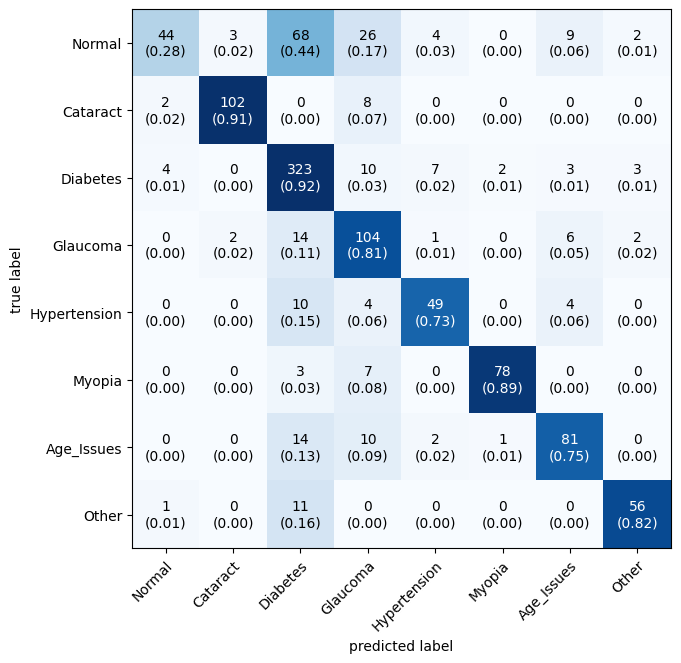

In [19]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract","Diabetes","Glaucoma","Hypertension","Myopia","Age_Issues","Other"],show_normed = True);

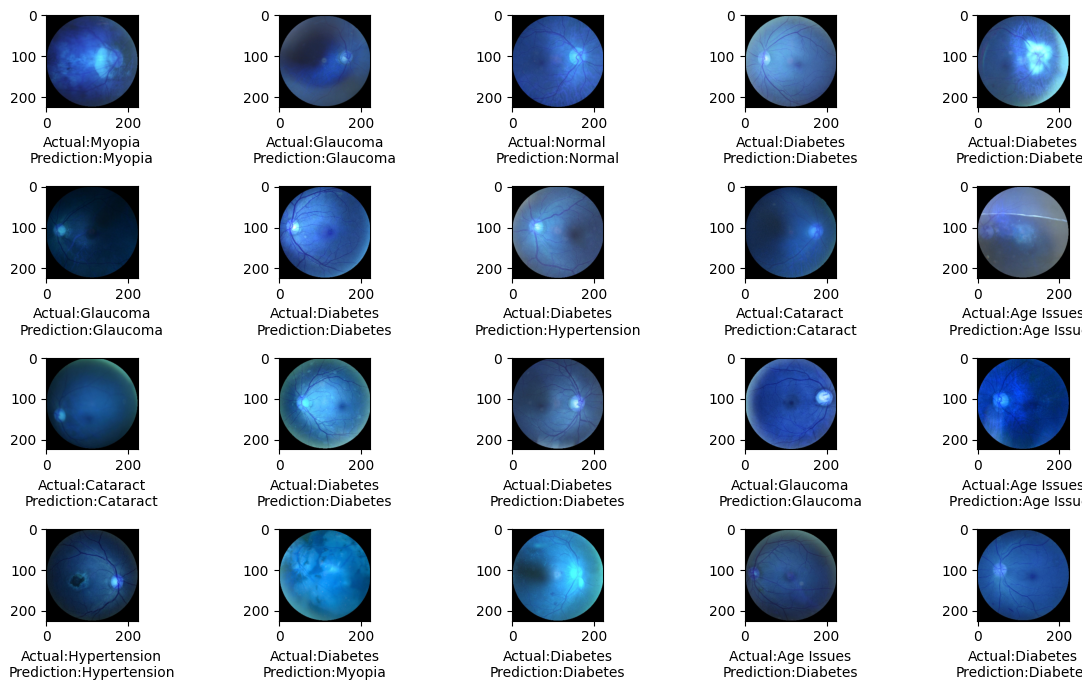

In [20]:
plt.figure(figsize=(12,7))
for i in range(20):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"
        
    if pred_category== 0:
        pred_label = "Normal"
    elif pred_category == 1 :
        pred_label = "Cataract"
    elif pred_category == 2:
        pred_label = "Diabetes"
    elif pred_category == 3:
        pred_label = "Glaucoma"
    elif pred_category == 4:
        pred_label = "Hypertension"
    elif pred_category == 5:
        pred_label = "Myopia"
    elif pred_category == 6:
        pred_label = "Age Issues"
    else:
        pred_label = "Other"
        
    plt.subplot(4,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()

In [22]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# evaluate the model
scores = []
for train_index, test_index in kfold.split(train_x):
     #get the training and testing data for this fold 
    X_train, X_test = train_x[train_index], train_x[test_index] 
    ytrain = to_categorical(train_y[train_index],num_classes=8) 
    ytest = to_categorical(train_y[test_index],num_classes=8) 
    # train the model
    model.fit(X_train, ytrain, epochs=5, batch_size=32, verbose=0) 
    # evaluate the model
    score = model.evaluate(X_test, ytest, verbose=0) 
    scores.append(score[1]) 
    # calculate the average performance
    mean_score = np.mean(scores) 
    std_score = np.std(scores) 
print("Accuracy: %.2f%% (+/- %.2f%%)" % (mean_score*100, std_score*100))


Accuracy: 90.29% (+/- 6.42%)


## K FOLD for model testing 